In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transforms3d as t3d
import math
import cv2
from sklearn.covariance import EllipticEnvelope

# Processing evaluation

In [2]:
def compute_average_quaternion(rot_matrices):
    quaternions = np.array([t3d.quaternions.mat2quat(mat) for mat in rot_matrices])
    avg_quaternion = np.mean(quaternions, axis=0)
    avg_quaternion /= np.linalg.norm(avg_quaternion)  # Normalize to ensure it's a valid quaternion
    return avg_quaternion

def compute_rotation_errors_deg(real_quaternion, estimated_rotations):
    real_rot = t3d.quaternions.quat2mat(real_quaternion)
    n = estimated_rotations.shape[0]
    errors_deg = np.zeros(n)

    for i in range(n):
        est_quat = t3d.quaternions.mat2quat(estimated_rotations[i])
    
        # Compute the quaternion difference
        quat_diff = t3d.quaternions.qmult(t3d.quaternions.qinverse(real_quaternion), est_quat)

        # rot_diff, _ = cv2.Rodrigues(t3d.quaternions.quat2mat(quat_diff))
        
        # Compute the angle of rotation in radians
        angle_rad = 2 * np.arccos(np.clip(quat_diff[0], -1.0, 1.0))  # quat_diff[0] is the scalar part of the quaternion
        angle_deg = np.degrees(angle_rad)
        errors_deg[i] = angle_deg

    return np.meerrors_deg

In [3]:
mses    = []
ptss    = []
centers = []

for i in range(0, 4):
    mse    = np.load(f"/calibration/data/hand_eye/processing/it_{i + 1}/best_mse.npy")
    pts    = np.load(f"/calibration/data/hand_eye/processing/it_{i + 1}/best_pts.npy")
    center = np.load(f"/calibration/data/hand_eye/processing/it_{i + 1}/best_center.npy")

    mses.append(mse)
    ptss.append(pts)
    centers.append(center)

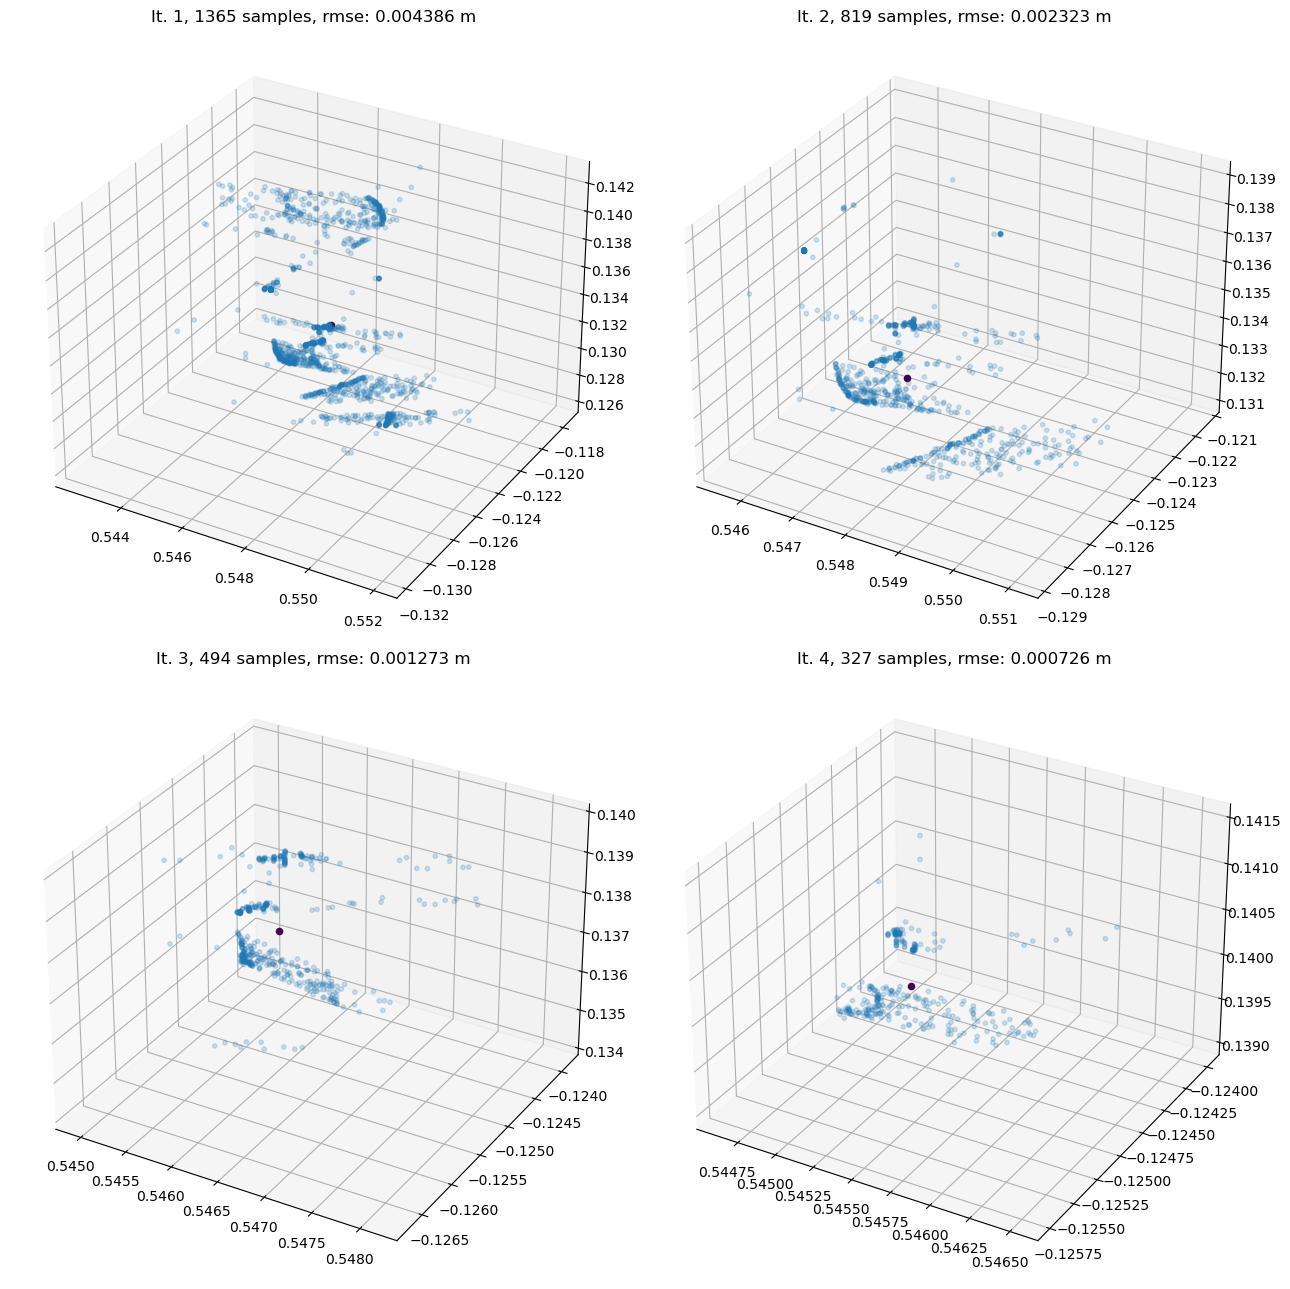

In [5]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(13, 13))

for i in range(0, 4):
    center     = centers[i]
    ax_inliers = axs[int(i / 2)][i % 2]
    points_3d  = ptss[i]
    ax_inliers.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=10, marker='o', alpha=0.2, zorder=-1)
    ax_inliers.scatter(center[0], center[1], center[2], marker = 'o', alpha=1, c=3, zorder=2)
    ax_inliers.set_title(f"It. {i + 1}, {len(ptss[i])} samples, rmse: {round(math.sqrt(mses[i]), 6)} m")
# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

In [6]:
best_h = np.load("/calibration/data/hand_eye/processing/it_1/best_eye2hand_h.npy")
best_h

array([[ 0.01450458, -0.00667542,  0.99987252,  0.05038218],
       [ 0.0086444 ,  0.99994118,  0.00655048,  0.08655706],
       [-0.99985744,  0.00854829,  0.01456143,  0.03200285],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [7]:
 np.load("/calibration/data/hand_eye/processing/eye2hand_h.npy")

array([[ 0.01459424, -0.0059357 ,  0.99987588,  0.04465573],
       [ 0.0067787 ,  0.99995999,  0.00583725,  0.08353654],
       [-0.99987052,  0.00669266,  0.01463389,  0.03176081],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])